# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [ ]:
DATA_FOLDER = '' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

In [ ]:
# Write your answer here

## Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

In [ ]:
# Write your answer here

## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [55]:
from IPython.core.display import HTML

DATA_FOLDER = 'Data'
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [56]:
import pandas as pd
import string
import math

#Load and cleanup data
frame = pd.read_excel(DATA_FOLDER+'/titanic.xls')
frame.ticket = frame.ticket.map(lambda tickets: str(tickets).strip('{}{}'.format(string.ascii_letters, string.punctuation)).split(' ')[-1])
frame.ticket = frame.ticket.map(lambda tickets: 0 if len(tickets)==0 else int(tickets))
frame

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


In [57]:
# 1. Describe the *type* and the *value range* of each attribute.

print("\npclass \n range: {}\n type: {}".format(frame.pclass.unique(), frame.pclass.dtype))
print("\nsurvived \n range: {}\n type: {}".format(frame.survived.unique(), frame.survived.dtype))
print("\nsex \n range: {}\n type: {}".format(frame.sex.unique(), frame.sex.dtype))
print("\nembarked \n range: {}\n type: {}".format(frame.embarked.unique(), frame.embarked.dtype))
print("\nparch \n range: {}-{}\n type: {}".format(frame.parch.min(), frame.parch.max(), frame.parch.dtype))
print("\nsibsp \n range: {}-{}\n type: {}".format(frame.sibsp.min(), frame.sibsp.max(), frame.sibsp.dtype))
print("\nage \n range: {}-{}\n type: {}".format(frame.age.min(), frame.age.max(), frame.age.dtype))
print("\nticket \n range: {}-{}\n type: {}".format(frame.ticket.min(), frame.ticket.max(), frame.ticket.dtype))
print("\nfare \n range: {}-{}\n type: {}".format(frame.fare.min(), frame.fare.max(), frame.fare.dtype))
print("\nbody \n range: {}-{}\n type: {}".format(frame.body.min(), frame.body.max(), frame.body.dtype))
print("\nboat \n range: {}\n type: {}".format(frame.boat.unique(), frame.boat.dtype))
print("\ncabin \n range: {}\n type: {}".format(frame.cabin.unique(), frame.cabin.dtype))
print("\nname \n range: {}\n type: {}".format(frame.name.unique(), frame.name.dtype))
print("\nhome.dest \n range: {}\n type: {}".format(frame['home.dest'].unique(), frame['home.dest'].dtype))


pclass 
 range: [1 2 3]
 type: int64

survived 
 range: [1 0]
 type: int64

sex 
 range: ['female' 'male']
 type: object

embarked 
 range: ['S' 'C' nan 'Q']
 type: object

parch 
 range: 0-9
 type: int64

sibsp 
 range: 0-8
 type: int64

age 
 range: 0.1667-80.0
 type: float64

ticket 
 range: 0-3101317
 type: int64

fare 
 range: 0.0-512.3292
 type: float64

body 
 range: 1.0-328.0
 type: float64

boat 
 range: [2 '11' nan '3' '10' 'D' '4' '9' '6' 'B' '8' 'A' '5' '7' 'C' '14' '2' '5 9'
 '13' '1' '15' '5 7' '8 10' '12' '16' '13 15 B' 'C D' '15 16' '13 15']
 type: object

cabin 
 range: ['B5' 'C22 C26' 'E12' 'D7' 'A36' 'C101' nan 'C62 C64' 'B35' 'A23' 'B58 B60'
 'D15' 'C6' 'D35' 'C148' 'C97' 'B49' 'C99' 'C52' 'T' 'A31' 'C7' 'C103'
 'D22' 'E33' 'A21' 'B10' 'B4' 'E40' 'B38' 'E24' 'B51 B53 B55' 'B96 B98'
 'C46' 'E31' 'E8' 'B61' 'B77' 'A9' 'C89' 'A14' 'E58' 'E49' 'E52' 'E45'
 'B22' 'B26' 'C85' 'E17' 'B71' 'B20' 'A34' 'C86' 'A16' 'A20' 'A18' 'C54'
 'C45' 'D20' 'A29' 'C95' 'E25' 'C111' 'C23

<b>pclass</b>, <b>survived</b> and <b>sex</b> can be categorical values. These are deviding the dataset to reasonably smaller subsets
<b>embarked</b> can be also considered as categorical value if we decide to eliminate the samples that have 'nan' value in this column

In [58]:
#Transform the attributes that can be `Categorical`. 
frame['pclass'] = frame.pclass.astype('category')
frame['survived'] = frame.survived.astype('category')
frame['sex'] = frame.sex.astype('category')
frame['embarked'] = frame.embarked.astype('category')

In [59]:
#Drop columns that won't be used furhter
clean_frame = frame.drop(['sibsp', 'parch', 'ticket', 'fare', 'body', 'home.dest', 'boat', 'name'], axis=1)

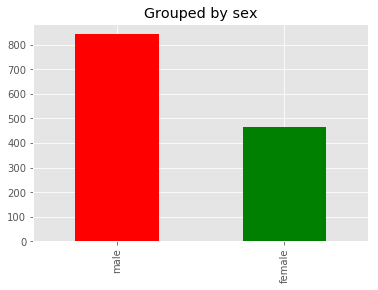

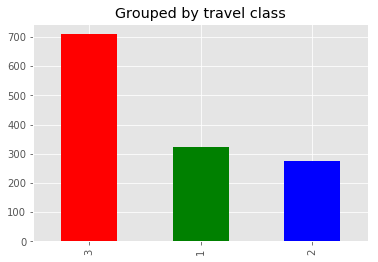

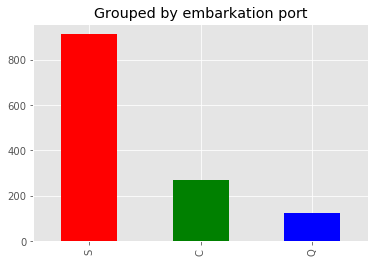

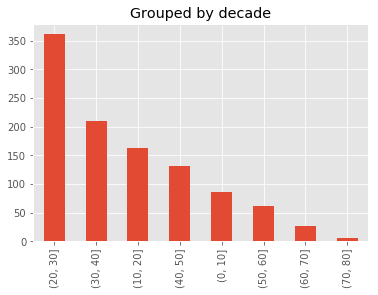

In [60]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

#Plot histograms for the *travel class*, *embarkation port*,
#*sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

clean_frame['sex'].value_counts().plot(kind='bar', color=['r','g'], title='Grouped by sex')
plt.show()

clean_frame['pclass'].value_counts().plot(kind='bar', color=['r','g','b'], title='Grouped by travel class')
plt.show()

clean_frame['embarked'].value_counts().plot(kind='bar', color=['r','g','b'], title='Grouped by embarkation port')
plt.show()

pd.cut(clean_frame.age, [0,10,20,30,40,50,60,70,80]).value_counts().plot(kind='bar', title='Grouped by decade')
plt.show()

In [61]:
for c in clean_frame.cabin.values:
    if len(str(c).split(' '))>1:
        print(c) 

C22 C26
C22 C26
C22 C26
C22 C26
C62 C64
C62 C64
B58 B60
B58 B60
B51 B53 B55
B51 B53 B55
B51 B53 B55
B96 B98
B96 B98
B96 B98
B96 B98
B58 B60
C23 C25 C27
C23 C25 C27
C23 C25 C27
C23 C25 C27
C23 C25 C27
C23 C25 C27
D10 D12
D10 D12
B82 B84
B52 B54 B56
B57 B59 B63 B66
B57 B59 B63 B66
B57 B59 B63 B66
B57 B59 B63 B66
B57 B59 B63 B66
C55 C57
C55 C57
E39 E41
F G63
F G63
F E57
F E46
F G73
F E69
F G73


According to [this](https://www.encyclopedia-titanica.org/titanic-deckplans/g-deck.html) map, we assume that the starting letter for each value represent the floor on which the person stays. For the cases where we have for exemple 'F G63' we assume that the person stayed on floor F in part G cabin 63. When there are more than one value as cabin for the same person we noticed that these cabins are always on the same floor (showed above). 

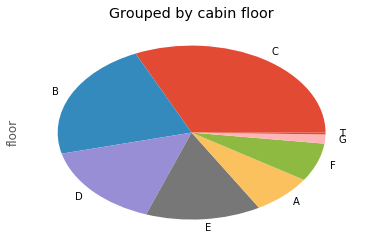

In [69]:
#Calculate the proportion of passengers by cabin floor. Present your results in a pie chart

#Add new column named floor
clean_frame['floor'] = clean_frame.cabin.dropna().map(lambda f: f[0])
#Make it categorical 
clean_frame['floor'] = clean_frame.floor.astype('category')
#Show the piechart
clean_frame['floor'].value_counts().plot(kind='pie', title='Grouped by cabin floor')
plt.show()

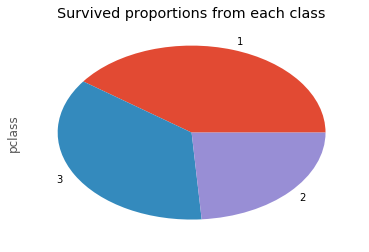

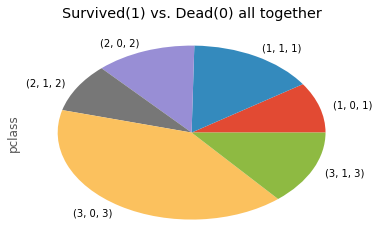

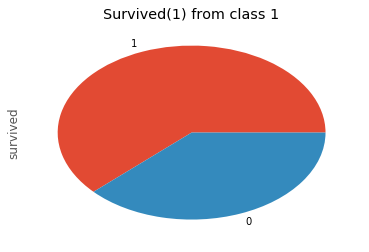

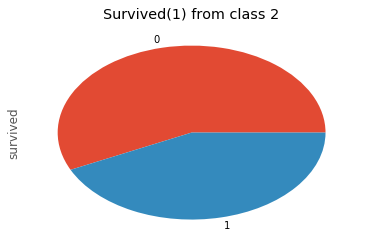

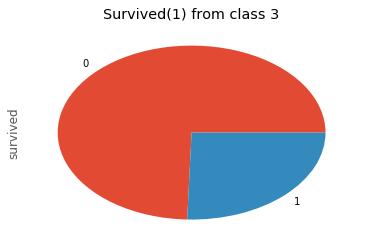

In [135]:
#For each travel class, calculate the proportion of the passengers that survived.
#Present your results in pie charts.
clean_frame[clean_frame.survived==1]['pclass'].value_counts().plot(kind='pie', title='Survived proportions from each class')
plt.show()
clean_frame.groupby(['pclass', 'survived']).pclass.value_counts().plot(kind='pie', title='Survived(1) vs. Dead(0) all together')
plt.show()
clean_frame[clean_frame.pclass==1]['survived'].value_counts().plot(kind='pie', title='Survived(1) from class 1')
plt.show()
clean_frame[clean_frame.pclass==2]['survived'].value_counts().plot(kind='pie', title='Survived(1) from class 2')
plt.show()
clean_frame[clean_frame.pclass==3]['survived'].value_counts().plot(kind='pie', title='Survived(1) from class 3')
plt.show()

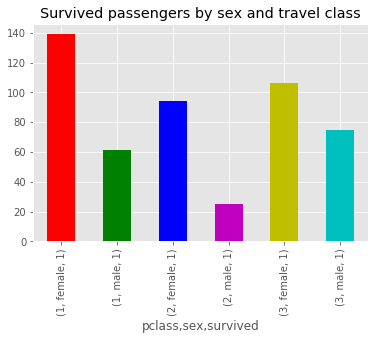

In [176]:
#Calculate the proportion of the passengers that survived by travel class and sex.
#Present your results in a single histogram.
grouped = clean_frame[clean_frame.survived==1].groupby(['pclass', 'sex'])

grouped.survived.value_counts().plot(kind='bar', color=['r','g','b','m','y', 'c'], title='Survived passengers by sex and travel class')
plt.show()

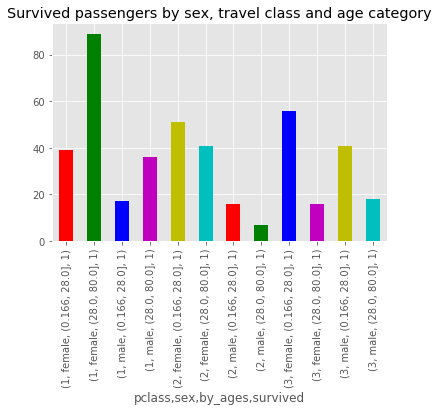

In [197]:
#Create 2 equally populated age categories and calculate survival proportions by age category, travel class and sex. 
by_ages = pd.qcut(clean_frame.age, 2)
clean_frame['by_ages'] = by_ages

grouped = clean_frame[clean_frame.survived==1].groupby(['pclass', 'sex', 'by_ages'])
grouped.survived.value_counts().plot(kind='bar', color=['r','g','b','m','y', 'c'], title='Survived passengers by sex, travel class and age category')
plt.show()

In [213]:
#Present your results in a DataFrame with unique index.
clean_frame['id'] = range(len(clean_frame))
clean_frame = clean_frame.set_index(['id'])
clean_frame

,pclass,survived,sex,age,cabin,embarked,floor,by_ages
id,,,,,,,,
0,1,1,female,29.0000,B5,S,B,"(28.0, 80.0]"
1,1,1,male,0.9167,C22 C26,S,C,"(0.166, 28.0]"
2,1,0,female,2.0000,C22 C26,S,C,"(0.166, 28.0]"
3,1,0,male,30.0000,C22 C26,S,C,"(28.0, 80.0]"
4,1,0,female,25.0000,C22 C26,S,C,"(0.166, 28.0]"
5,1,1,male,48.0000,E12,S,E,"(28.0, 80.0]"
6,1,1,female,63.0000,D7,S,D,"(28.0, 80.0]"
7,1,0,male,39.0000,A36,S,A,"(28.0, 80.0]"
8,1,1,female,53.0000,C101,S,C,"(28.0, 80.0]"
